In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac

from mdps.whited_CEF import cMDPWhited_CEF
from mdps.whited_tax import cMDPWhited_tax
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

## CEF

In [2]:
# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited_CEF(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Capital(k)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

    fig_, ax_3 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_4 = ax_3.twinx()
    ax_3.plot(x, gt_obs_arr_[:,1], 'r-')
    ax_4.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_3.set_xlabel('time step')
    ax_3.set_ylabel('Shock(z)', color='r')
    ax_4.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [3]:
c = {"context_distribution":
        ConstantDistribution(dim=7, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15, 0.08, 0.028]))
    }

### 1. ppo

In [4]:
ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-04 21:56:53,458	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-04 21:56:53,459	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-04-04 21:56:55,508	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-04-04 21:57:04,898	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4345576043602.0x the scale of `vf_clip_param`. This means that it will take more than 4345576043602.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -43455760436015.375


2022-04-04 21:57:14,103	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2190668395011.0x the scale of `vf_clip_param`. This means that it will take more than 2190668395011.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:57:23,078	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 84161154301.0x the scale of `vf_clip_param`. This means that it will take more than 84161154301.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:57:32,586	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 13448667357.0x the scale of `vf_clip_param`. This means that it will take more than 13448667357.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:57:42,374	WARNING ppo.py:245 -- The magnitude of you

5 -49485198.735520296


2022-04-04 21:58:02,235	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1300544.0x the scale of `vf_clip_param`. This means that it will take more than 1300544.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:58:12,153	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 152105.0x the scale of `vf_clip_param`. This means that it will take more than 152105.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:58:22,112	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 9772.0x the scale of `vf_clip_param`. This means that it will take more than 9772.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-04-04 21:58:32,125	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 

10 -1071.2740094872106
15 675.1265373317746
20 766.7387184686877
25 774.7022360893632
30 812.3297354091203


### 2. a3c

In [5]:
ray.shutdown()
ray.init()

expert_a3c = a3c.A3CTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_a3c.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-04 22:02:51,659	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-04-04 22:02:51,666	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=34392) 2022-04-04 22:02:51,642	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!


0 nan
5 144.82294380126322
10 206.88610602235573
15 180.4553036095765
20 269.09695373771183
25 274.51606684299367
30 286.84768049886185


### 3. dqn

In [6]:
ray.shutdown()
ray.init()

expert_dqn = dqn.DQNTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_dqn.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-04 22:05:53,230	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -7401606635605.94
5 -5.214298019382953e+19
10 -1.595544756869128e+23
15 -7.033824856860706e+23


2022-04-04 22:06:55,045	WARNING logger.py:224 -- You are trying to log an invalid value (ray/tune/hist_stats/episode_reward=[-2.2268164121731033e+21, -4.738816428123156e+21, -9.210969574702366e+21, -5.557626911679451e+22, -1.0390507653349604e+22, -4.103730942947074e+22, -4.535618998505243e+21, -3.207852276059924e+22, -3.1427391402096816e+22, -8.635186675581664e+21, -2.7851211961319157e+23, -1.2786535843757476e+23, -2.9609334392072922e+22, -8.544797978935731e+23, -8.074447853743672e+22, -4.8897321792951917e+23, -4.9195770839192914e+23, -8.855780350168359e+23, -6.122262021569488e+23, -3.302212743744315e+23, -1.5064858361548094e+24, -4.36572832595134e+23, -1.5064857805903622e+24, -1.03747825118799e+24, -1.1518012588711823e+24, -1.728435713901691e+24, -9.745517797391952e+23, -1.232217799579807e+24, -1.8394108147657687e+24, -1.2238671123898781e+23, -1.2309329883289908e+24, -6.215998522938725e+23, -1.7284357913315853e+24, -8.903485006607936e+23, -4.841565105780148e+23, -6.748934633291104e+23

20 -8.964927423697794e+23
25 -3.5263344658324555e+23
30 34.37257319858415


### 4. sac

In [7]:
ray.shutdown()
ray.init()

expert_sac = sac.SACTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(35):
    res = expert_sac.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-04-04 22:08:07,410	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -1.4567904029555645e+18
5 -1.0925928022166735e+18
10 -8.740742417733388e+17
15 -7.283952014777823e+17
20 -6.243387441238132e+17
25 -5.462964011083365e+17
30 -4.8559680098518803e+17


### 5. Random

In [8]:
ray.shutdown()
ray.init()

expert_rdm = ppo.PPOTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

2022-04-04 22:10:23,309	WARNING util.py:57 -- Install gputil for GPU system monitoring.


In [9]:
r = np.zeros(500)
for i in range(500):
    gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)
    r[i] = sum(gt_rew_arr)
print(np.mean(r))

806.2184352887973


In [82]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert_sac, config=c)

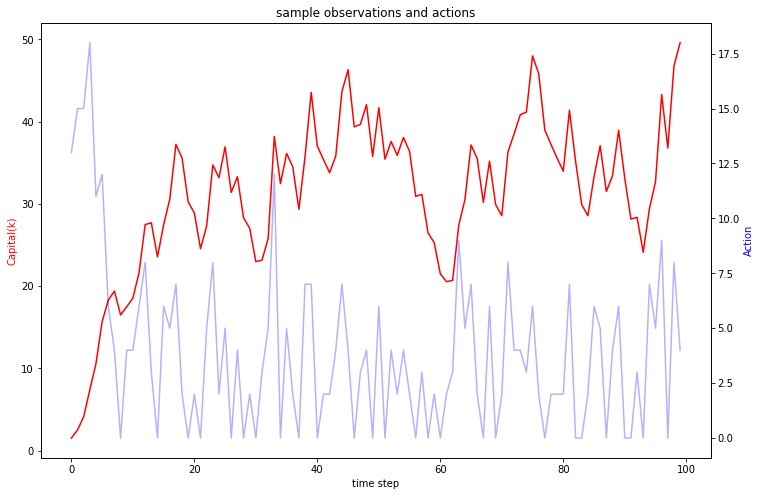

(pid=None) [2022-04-05 21:49:42,580 C 35140 40048] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 8247328359524230500
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-04-06 21:35:23,847	WARNING worker.py:1245 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff1db318184e581d9e5bc112a001000000 Worker ID: d7143ae53af55a0fc7f8ad1b986bfa898ff10954a54a7495975a58ff Node ID: 3daee4914afd9adb9d8e0b5b63fb3f346a5539b9dd08d69b5b872fe3 Worker IP address: 127.0.0.1 Worker port: 50167 Worker PID: 32628
2022-04-06 21:35:23,854	WARNING worker.py:1245 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff3ce99f

In [84]:
fig_, ax_1 = plt.subplots()
fig_.set_size_inches(12, 8, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, gt_obs_arr[:,0], 'r-')
ax_2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax_1.set_xlabel('time step')
ax_1.set_ylabel('Capital(k)', color='r')
ax_2.set_ylabel('Action', color='b')
plt.title('sample observations and actions')
# plt.savefig('basic_cef_sac.pdf')
plt.show()